In [1]:
print(1)

1


In [2]:
# !pip install talos deap bitstring

In [3]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import math
import talos as ta

from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.layers import LSTM, Input, Dense
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.activations import relu, elu

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from sklearn.model_selection import train_test_split as split
from bitstring import BitArray


Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/chances/plots.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/traitlets/config/applicatio

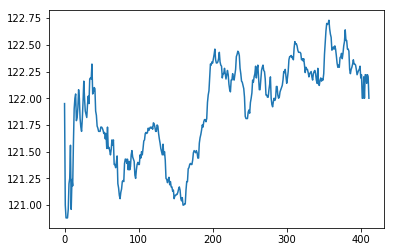

In [4]:
#Read data
#dataset = pandas.read_csv('IBM.1Min.TradesOnly.20160128.csv', usecols=[6], engine='python', skipfooter=3)
dataset = pandas.read_csv('IBM.1Min.TradesOnly.20160128.csv')
plt.plot(dataset["LowTradePrice"])
plt.show()

In [5]:
#COnvert date to  values from Date column of data
#dataset["Time"] = pandas.to_datetime(dataset["TimeBarStart"],format='%H:%M')

#Treat Irregularly spaced intervals
#res = dataset.resample('s').interpolate().resample('15T').asfreq().dropna()



In [6]:
# fix random seed for reproducibility
np.random.seed(7)

In [7]:
# load the dataset
dataframe = pandas.read_csv('IBM.1Min.TradesOnly.20160128.csv', usecols=[6], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
dataframe.head(5)

,LastTradePrice
0,121.95
1,121.78
2,120.88
3,120.88
4,120.88


In [8]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [9]:
# split into train and test sets
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


In [10]:
 #convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [11]:
#The X will have values from the past (e.g. 1 to t-1) and Y will be future value at time t

def prepare_dataset(data, window_size):
    X, Y = np.empty((0,window_size)), np.empty((0))
    for i in range(len(data)-window_size-1):
        X = np.vstack([X,data[i:(i + window_size),0]])
        Y = np.append(Y,data[i + window_size,0])   
    X = np.reshape(X,(len(X),window_size,1))
    Y = np.reshape(Y,(len(Y),1))
    return X, Y

In [12]:
# GA to optimise LSTM hyperparameter

def train_evaluate(ga_individual_solution):   
    # Decode GA solution to integer for window_size and num_units
    window_size_bits = BitArray(ga_individual_solution[0:6])
    num_units_bits = BitArray(ga_individual_solution[6:]) 
    window_size = window_size_bits.uint
    num_units = num_units_bits.uint
    print('\nWindow Size: ', window_size, ', Num of Units: ', num_units)
    
    # Return fitness score of 100 if window_size or num_unit is zero
    if window_size == 0 or num_units == 0:
        return 100, 
    
    # Segment the train_data based on new window_size; split into train and validation (80/20)
    X,Y = prepare_dataset(train_data,window_size)
    X_train, X_val, y_train, y_val = split(X, Y, test_size = 0.20, random_state = 1120)
    
    # Train LSTM model and predict on validation set
    inputs = Input(shape=(window_size,1))
    x = LSTM(num_units, input_shape=(window_size,1))(inputs)
    predictions = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=5, batch_size=10,shuffle=True)
    y_pred = model.predict(X_val)
    
    # Calculate the RMSE score as fitness score for GA
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('Validation RMSE: ', rmse,'\n')
    
    return rmse,

In [13]:

population_size = 4
num_generations = 4
gene_length = 10

# Minimize the RMSE score, that's why using -1.0. 
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = False)


Window Size:  23 , Num of Units:  8


NameError: name 'train_data' is not defined

In [ ]:
best_individuals = tools.selBest(population,k = 1)
best_window_size = None
best_num_units = None

for bi in best_individuals:
    window_size_bits = BitArray(bi[0:6])
    num_units_bits = BitArray(bi[6:]) 
    best_window_size = window_size_bits.uint
    best_num_units = num_units_bits.uint
    print('\nWindow Size: ', best_window_size, ', Num of Units: ', best_num_units)

In [ ]:
# from sklearn import datasets, linear_model

# # Create linear regression object
# regr = linear_model.LinearRegression()

# regr.fit(trainX,trainY)
# regr.coef_, regr.intercept_

In [ ]:
# reshape into X=t and Y=t+1
#using best best_window_size as look_back
#look_back = 1
trainX, trainY = prepare_dataset(train, best_window_size)
testX, testY = prepare_dataset(test, best_window_size)

In [ ]:
train.shape,test.shape


In [ ]:
# reshape into X=t and Y=t+1
# look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
#plt.plot(train)


# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
trainX.shape,testX.shape

In [ ]:
## Vanilla LSTM
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

In [ ]:
### Vanilla LSTM
# # create and fit the LSTM network
# model = Sequential()
# model.add(LSTM(4, input_shape=(1, look_back)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

inputs = Input(shape=(best_window_size,1))
x = LSTM(best_num_units, input_shape=(best_window_size,1))(inputs)
predictions = Dense(1, activation='linear')(x)
model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(trainX, trainY, epochs=5, batch_size=10,shuffle=True)

print (model.summary())
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# y_pred = model.predict(testX)

# rmse = np.sqrt(mean_squared_error(testY, y_pred))
# print('Test RMSE: ', rmse)


In [ ]:
## Old- With normalization

import numpy as np
# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
testY.shape,testPredict.shape

In [ ]:

# invert predictions
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)



In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))
# calculate  mean adbolute percentage error
# trainPScore=np.mean(np.abs((trainY[0], trainPredict[:,0]) / trainY[0])) * 100
# print('Train Percentage Score: %.2f MAPE' % (trainPScore))
# testPScore=np.mean(np.abs((testY[0], testPredict[:,0]) / testY[0])) * 100
# print('Test Percentage Score: %.2f MAPE' % (testPScore))


In [ ]:
## Without normalization

import numpy as np
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))
# calculate  mean adbolute percentage error
# trainPScore=np.mean(np.abs((trainY[0], trainPredict[:,0]) / trainY[0])) * 100
# print('Train Percentage Score: %.2f MAPE' % (trainPScore))
# testPScore=np.mean(np.abs((testY[0], testPredict[:,0]) / testY[0])) * 100
# print('Test Percentage Score: %.2f MAPE' % (testPScore))


In [ ]:
plt.plot(testY)
plt.plot(testPredict)

In [ ]:
look_back= best_window_size

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:

y_true, y_pred = np.array(testY[0]), np.array(testPredict[:,0])
testPScore=np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print('Test Percentage Score: %.2f MAPE' % (testPScore))

In [ ]:
 
forecast_7=numpy.random.rand(7,4)

forecast_7 = numpy.reshape(forecast_7, (forecast_7.shape[0], 1, forecast_7.shape[1]))
forecast=[]
forecast = model.predict(forecast_7)
forecast = scaler.inverse_transform(forecast)

In [ ]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset[train_size:len(dataset),:]))
# plt.plot(trainPredictPlot)
plt.plot(forecast[train_size:len(dataset),:])
plt.show()